# Use ML + XAI to build strong linear model

Data (synthetic, but quite realistic via copulas): 1 Mio insurance policies and their corresponding claim counts, see

Mayer, M., Meier, D. and Wuthrich, M.V. (2023) 
SHAP for Actuaries: Explain any Model. 
http://dx.doi.org/10.2139/ssrn.4389797

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.datasets import fetch_openml
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_poisson_deviance
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
# We need preview version of glum that adds formulaic API
# !pip install git+https://github.com/Quantco/glum@glum-v3#egg=glum
from glum import GeneralizedLinearRegressor

## Load and describe data

In [4]:
df = fetch_openml(data_id=45106, parser="pandas").frame
df.head()

,year,town,driver_age,car_weight,car_power,car_age,claim_nb
0,2018.0,1.0,51.0,1760.0,173.0,3.0,0.0
1,2019.0,1.0,41.0,1760.0,248.0,2.0,0.0
2,2018.0,1.0,25.0,1240.0,111.0,2.0,0.0
3,2019.0,0.0,40.0,1010.0,83.0,9.0,0.0
4,2018.0,0.0,43.0,2180.0,169.0,5.0,0.0


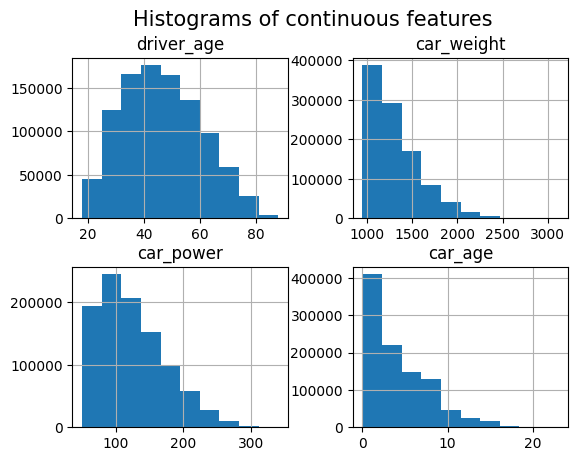

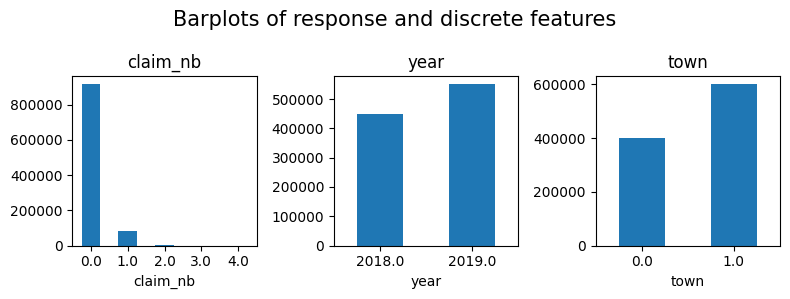

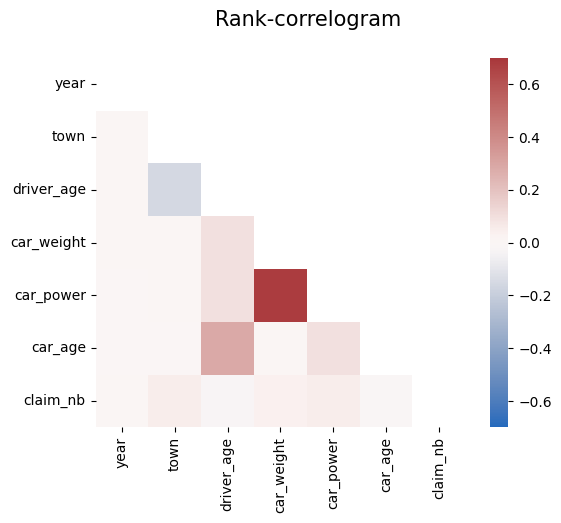

In [5]:
# Continuous features
df.hist(["driver_age", "car_weight", "car_power", "car_age"])
_ = plt.suptitle("Histograms of continuous features", fontsize=15)

# Response and discrete features
fig, axes = plt.subplots(figsize=(8, 3), ncols=3)

for v, ax in zip(["claim_nb", "year", "town"], axes):
    df[v].value_counts(sort=False).sort_index().plot(kind="bar", ax=ax, rot=0, title=v)
plt.suptitle("Barplots of response and discrete features", fontsize=15)
plt.tight_layout()
plt.show()

# Rank correlations
corr = df.corr("spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.suptitle("Rank-correlogram", fontsize=15)
_ = sns.heatmap(
    corr, mask=mask, vmin=-0.7, vmax=0.7, center=0, cmap="vlag", square=True
)

## Modeling

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("claim_nb", axis=1), df["claim_nb"], test_size=0.1, random_state=30
)

We use a LightGBM model with Poisson objective. Hyperparameters are tuned via cross-validation and early stopping (code not shown here).

In [7]:
# Tuning step not shown. Number of boosting rounds found via early stopping on CV performance
params = dict(
    learning_rate=0.05,
    objective="poisson",
    num_leaves=7,
    min_child_samples=50,
    min_child_weight=0.001,
    colsample_bynode=0.8,
    subsample=0.8,
    reg_alpha=3,
    reg_lambda=5,
    verbose=-1,
)

model_lgb = LGBMRegressor(n_estimators=360, **params)
_ = model_lgb.fit(X_train, y_train)

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "d:\responsible_ml_lecture\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


### SHAP analysis

- Decompose 2000 training observations via TreeSHAP.
- Note: SHAP values are on "raw" scale (here log due to Poisson loss).

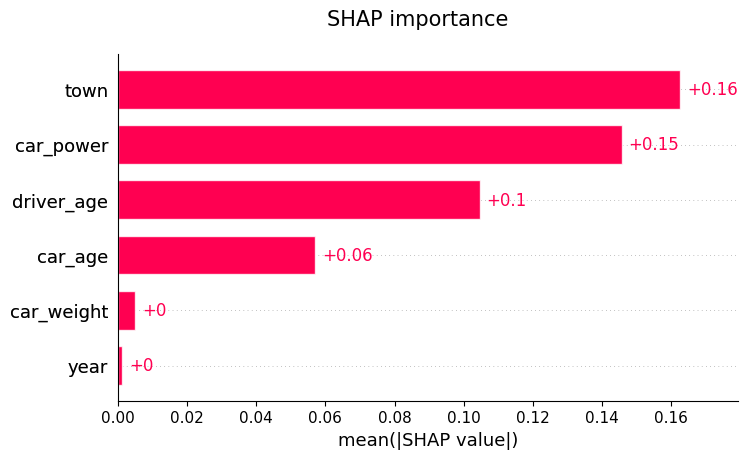

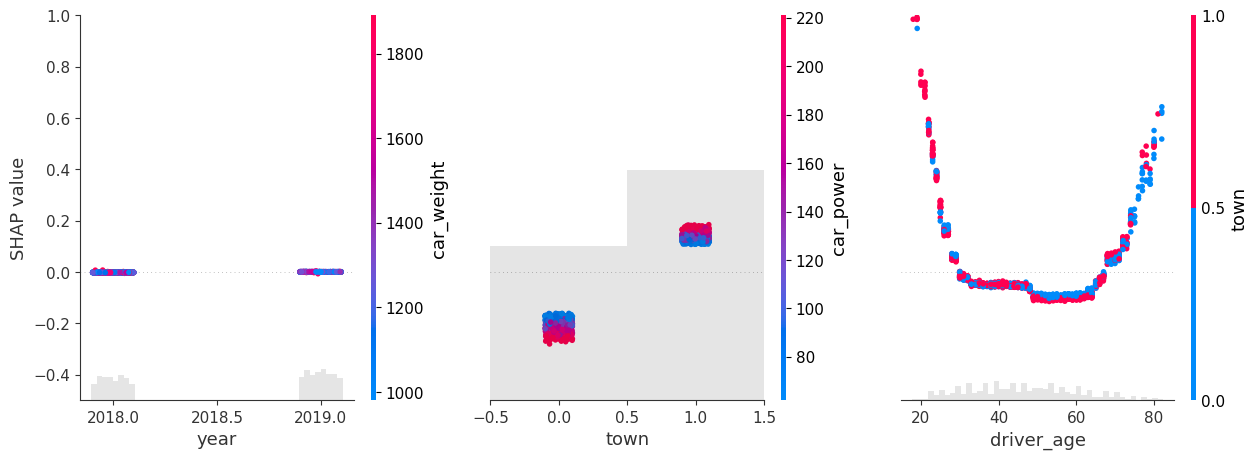

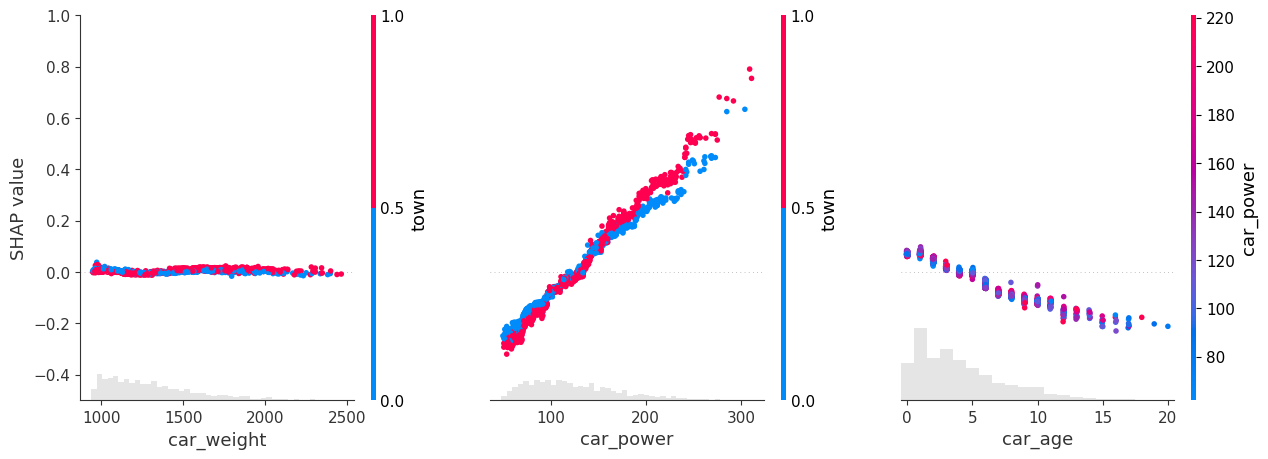

In [8]:
X_explain = X_train.sample(n=2000, random_state=937)
explainer = shap.Explainer(model_lgb)
shap_val = explainer(X_explain)

plt.suptitle("SHAP importance", fontsize=15)
shap.plots.bar(shap_val)

for s in [shap_val[:, 0:3], shap_val[:, 3:]]:
    shap.plots.scatter(s, color=shap_val, ymin=-0.5, ymax=1)

# Build strong GLM

The SHAP analysis of the boosted trees model reveals:

- `car_weight` and `year` might be dropped (depending on the specific aim of the model).
- `driver_age` effect is hightly non-linear.
- There seems to be an interaction between `car_power` and `town`.

Let's build a GLM with these insights. Two important things:

1. [Glum](https://github.com/Quantco/glum) is an extremely powerful LGM implementation that was inspired by a pull request of our Christian Lorentzen.
2. In the upcoming version 3.0, it adds a formula API based of [formulaic](https://github.com/matthewwardrop/formulaic), a very performant formula parser. This gives a very easy way to add interaction effects, regression splines, dummy encodings etc.

In [9]:
model_glm = GeneralizedLinearRegressor(
    family="poisson",
    l1_ratio=1.0,
    alpha=1e-10,
    formula="car_power * C(town) + bs(driver_age, 7) + car_age",
)
_ = model_glm.fit(X_train, y=y_train)

## Some PDPs

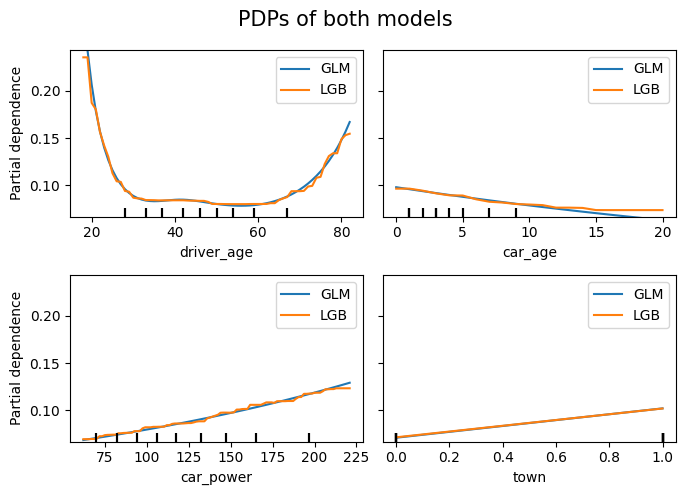

In [10]:
# PDPs of both models
fig, ax = plt.subplots(2, 2, figsize=(7, 5))
cols = ("tab:blue", "tab:orange")
for color, name, model in zip(cols, ("GLM", "LGB"), (model_glm, model_lgb)):
    disp = PartialDependenceDisplay.from_estimator(
        model,
        features=["driver_age", "car_age", "car_power", "town"],
        X=X_explain,
        ax=ax if name == "GLM" else disp.axes_,
        line_kw={"label": name, "color": color},
    )
fig.suptitle("PDPs of both models", fontsize=15)
fig.tight_layout()

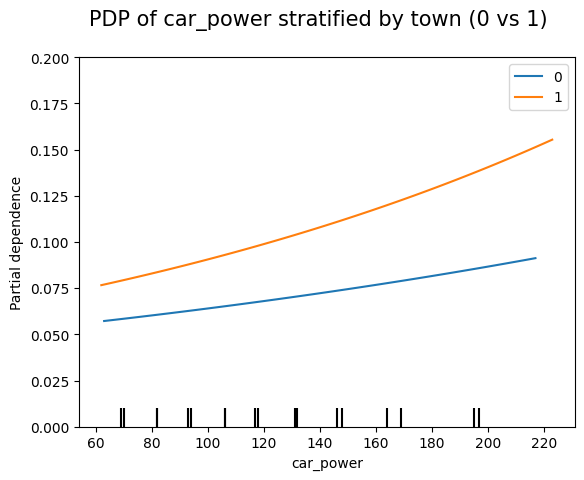

In [11]:
# Stratified PDP of car_power
for color, town in zip(("tab:blue", "tab:orange"), (0, 1)):
    mask = X_explain.town == town
    disp = PartialDependenceDisplay.from_estimator(
        model_glm,
        features=["car_power"],
        X=X_explain[mask],
        ax=None if town == 0 else disp.axes_,
        line_kw={"label": town, "color": color},
    )
plt.suptitle("PDP of car_power stratified by town (0 vs 1)", fontsize=15)
_ = plt.ylim(0, 0.2)

## Performance

Mean Poisson deviance of the two models (and for comparison also an intercept only model), evaluated on the test data.

In [12]:
model_dummy = DummyRegressor().fit(X_train, y=y_train)
deviance_null = mean_poisson_deviance(y_test, model_dummy.predict(X_test)) 

dev_imp = []
for name, model in zip(("GLM", "LGB", "Null"), (model_glm, model_lgb, model_dummy)):
    dev_imp.append((name, mean_poisson_deviance(y_test, model.predict(X_test))))
pd.DataFrame(dev_imp, columns=["Model", "Mean_Poisson_Deviance"])

,Model,Mean_Poisson_Deviance
0,GLM,0.432192
1,LGB,0.432283
2,Null,0.442581


## Permutation SHAP

In [ ]:
# Will take long
explainer = shap.Explainer(model_glm.predict, masker=X_explain.head(100), algorithm="permutation")
shap_val = explainer(X_explain.head(400))

plt.suptitle("SHAP importance", fontsize=15)
shap.plots.bar(shap_val)

for s in [shap_val[:, 0:3], shap_val[:, 3:]]:
    shap.plots.scatter(s, color=shap_val, ymin=-0.5, ymax=1)